In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
# import gradient 
import torch

from nb_functions import nearest_neighbors_with_occlusion_kdtree_smart, distance_cutoff, cutoff_and_knn, knn



In [6]:
class Simulation:
    def __init__(self, n_cells):
        self.n_cells = n_cells


        self.cell_qs = np.array([[0.0,1.0] for _ in range(n_cells**2)])


        # add withinin a random circle of radius 16
        self.cell_rs = np.random.rand(n_cells**2, 2)*10 - 5

        self.cell_rs = torch.tensor(self.cell_rs, requires_grad=True)
        self.cell_qs = torch.tensor(self.cell_qs, requires_grad=True)

        self.dt = 0.03
        
        self.nbs = self.voronoi_neighbors(self.cell_rs.detach().numpy())

        self.elongated_cells = torch.tensor([False for _ in range(n_cells**2)])

        self.time = 0

        # self.nb_function = lambda points: distance_cutoff(points, 5)
        self.nb_function = lambda points: cutoff_and_knn(points, cutoff = 6, k = 6)

    def S(self, ri, rj):
        return 1

    def V(self, ri, rj, qi, qj, elongated=False):
        dij = rj - ri
        
        # rij = np.linalg.norm(dij)
        # torch len
        rij = torch.norm(dij)

        if elongated:
            rij_t = rij - (torch.abs(torch.dot(dij/rij, qi))-0.5) 
        else:

            rij_t = rij

        return torch.exp(-rij_t) - self.S(ri, rj)*torch.exp(-rij_t/5)


    def voronoi_neighbors(self, points):
        vor = Voronoi(points) 
        neighbors = {i: set() for i in range(len(points))}
        for i, j in vor.ridge_points:
            if i == -1 or j == -1:
                continue
            if i == j:
                continue
            neighbors[i].add(j)
            neighbors[j].add(i)
        return neighbors


    def step(self, should_get_new_nbs):
        if should_get_new_nbs:
            self.nbs = list(self.nb_function(self.cell_rs.detach().numpy()))


        for i in range(self.n_cells**2):
            nb = torch.tensor(list(self.nbs[i]), dtype=torch.int32)


            # get V for all neighbors
            V = torch.tensor(0.0)
            for j in nb:
                V += self.V(self.cell_rs[i], self.cell_rs[j], self.cell_qs[i], self.cell_qs[j], self.elongated_cells[j])

            # get gradient of V
            V.backward()

            # update r
            with torch.no_grad():
                self.cell_rs -= self.cell_rs.grad*self.dt

            # zero grad
            self.cell_rs.grad.zero_()


    def show(self):
        plt.scatter(self.cell_rs.detach().numpy()[:,0], self.cell_rs.detach().numpy()[:,1], c = self.elongated_cells.numpy())
        plt.title(f"Time: {self.time}")
        plt.show()

    def run(self):
        self.show()
        for i in range(1000):
            self.step(should_get_new_nbs = i%50 == 0)

            self.time += self.dt

            if i % 200 == 0:
                self.show()

            if i == 500:
                self.elongated_cells[45] = True
                self.elongated_cells[55] = True
                self.elongated_cells[65] = True


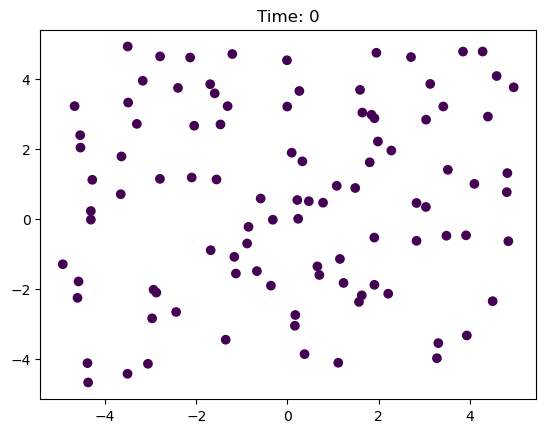

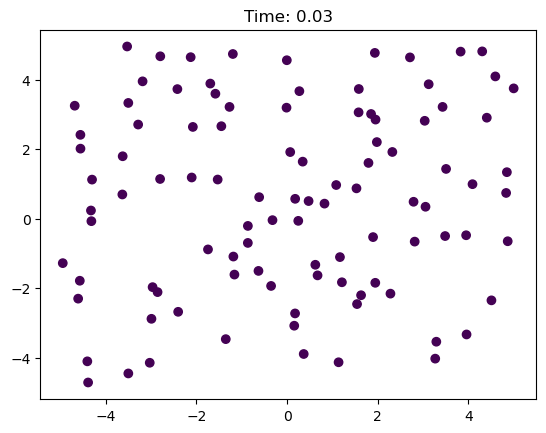

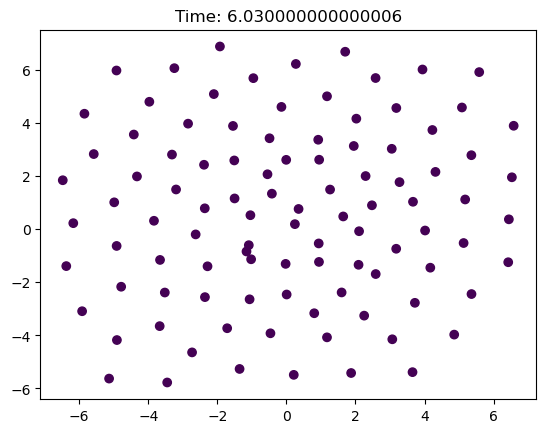

In [ ]:
sim = Simulation(10)
sim.run()

In [ ]:
sim.cell_rs

tensor([[1.1005e-01, 1.0868e-01],
        [1.0493e-01, 2.2596e+00],
        [4.3765e-02, 4.5172e+00],
        [9.8475e-02, 6.7291e+00],
        [7.3620e-02, 8.8654e+00],
        [5.3672e-02, 1.1145e+01],
        [9.2966e-02, 1.3373e+01],
        [2.0757e-02, 1.5539e+01],
        [9.0335e-02, 1.7743e+01],
        [1.0730e-01, 1.9901e+01],
        [2.2601e+00, 1.0512e-01],
        [2.1765e+00, 2.1764e+00],
        [2.2292e+00, 4.3521e+00],
        [2.2298e+00, 6.6090e+00],
        [2.2151e+00, 8.8035e+00],
        [2.2367e+00, 1.1038e+01],
        [2.2247e+00, 1.3267e+01],
        [2.1833e+00, 1.5521e+01],
        [2.2226e+00, 1.7789e+01],
        [2.2654e+00, 1.9896e+01],
        [4.4728e+00, 4.5014e-02],
        [4.3518e+00, 2.2284e+00],
        [4.4427e+00, 4.4428e+00],
        [4.4399e+00, 6.6661e+00],
        [4.4404e+00, 8.8929e+00],
        [4.4447e+00, 1.1111e+01],
        [4.4485e+00, 1.3326e+01],
        [4.4866e+00, 1.5596e+01],
        [4.3913e+00, 1.7818e+01],
        [4.515

array([[ 0.,  0.],
       [ 0., 10.],
       [ 0., 20.],
       [10.,  0.],
       [10., 10.],
       [10., 20.],
       [20.,  0.],
       [20., 10.],
       [20., 20.]])